In [2]:
import sqlite3
import sys
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import statsmodels.api as sm

sys.path.append('../')
from functions_env import DB_PATH

conn = sqlite3.connect(DB_PATH)
cursor = conn.cursor()

pd.set_option('mode.chained_assignment', None)

In [3]:
# Load and clean individuals' main information
df_individual = pd.read_sql_query("SELECT * FROM individuals_main_information", conn)
df_individual = df_individual[['individual_wikidata_id', 'birthyear']].dropna(subset=['birthyear'])
df_individual['decade'] = df_individual['birthyear'].apply(lambda x: int(x/10)*10)

# Load and clean individuals' regions
df_individual_region = pd.read_sql_query("SELECT * FROM individuals_regions", conn)
df_individual_region = df_individual_region[['individual_wikidata_id', 'region_name']].drop_duplicates()

# Load and clean identifiers meta-data
df_identifiers = pd.read_sql_query("SELECT * FROM identifiers", conn)
df_identifiers['country_name'].fillna('', inplace=True)
df_identifiers['identifier_name'] = df_identifiers.apply(lambda x: f"{x['identifier_name']} ({x['country_name']})" if x['country_name'] else x['identifier_name'], axis=1)
df_identifiers = df_identifiers.drop(['country_wikidata_id', 'count_records', 'identifier_url', 'country_name', 'identifier_name_country'], axis=1).drop_duplicates()

# Load and clean information about individuals and identifiers
df_ind_identifiers = pd.read_sql_query("SELECT * FROM individual_identifiers", conn)
df_ind_identifiers = pd.merge(df_ind_identifiers.drop('identifier_name', axis=1), df_identifiers, on='identifiers_wikidata_id', how='left')

# Clean and standardize identifier names
df_ind_identifiers['identifier_name'] = df_ind_identifiers['identifier_name'].replace('Freebase ID', 'Google Knowledge Graph ID')
df_ind_identifiers['identifiers_wikidata_id'] = df_ind_identifiers['identifiers_wikidata_id'].replace('P646', 'P2671')
df_ind_identifiers['identifier_name'] = df_ind_identifiers['identifier_name'].replace('Deutsche Biographie (GND) ID (Germany)', 'GND ID (Germany)')
df_ind_identifiers['identifiers_wikidata_id'] = df_ind_identifiers['identifiers_wikidata_id'].replace('P7902', 'P227')

# Remove unwanted objects and duplicates
df_ind_identifiers = df_ind_identifiers[~df_ind_identifiers['individual_name'].str.contains('Painter')]
df_ind_identifiers = df_ind_identifiers[~df_ind_identifiers['identifier_name'].str.contains('superceded|obsolete')]
df_ind_identifiers = df_ind_identifiers.drop_duplicates()

In [4]:
# Merge individual information with identifiers and regions
df_merged = pd.merge(pd.merge(df_individual, df_ind_identifiers, on='individual_wikidata_id'), df_individual_region, on='individual_wikidata_id')

# Prepare data for figure
df_fig = df_merged[['individual_wikidata_id', 'decade', 'identifier_name', 'region_name']].groupby(['identifier_name', 'region_name', 'decade'])['individual_wikidata_id'].count().rename("score").reset_index()

# Prepare country identifiers for merging
df_country_id = pd.read_sql_query("SELECT * FROM identifiers", conn)
df_country_id['country_name'].fillna('', inplace=True)
df_country_id['identifier_name'] = df_country_id.apply(lambda x: f"{x['identifier_name']} ({x['country_name']})" if x['country_name'] else x['identifier_name'], axis=1)
df_country_id = df_country_id[['identifier_name', 'country_name']].drop_duplicates()

# Merge country identifiers with figure data
df_fig = pd.merge(df_fig, df_country_id, on='identifier_name')

# Prepare data for 50-year decade aggregation
df_fig_fifty = df_fig.copy()
df_fig_fifty['decade'] = df_fig_fifty['decade'].apply(lambda x: round(x/50)*50)
df_fig_fifty = df_fig_fifty.groupby(['identifier_name', 'country_name', 'region_name', 'decade'])['score'].sum().reset_index()

In [5]:
df_fig_fifty.sample(10)

,identifier_name,country_name,region_name,decade,score
90258,Global Anabaptist Mennonite Encyclopedia Onlin...,,East Slavic,1700,1
66347,DoME artist ID,,Northwestern Europe,1750,54
199925,SEARCH on line catalogue ID (Italy),Italy,Muslim world,-400,2
38341,CANTIC ID (Spain),Spain,Switzerland,1450,2
83280,Flemish Public Libraries ID (Belgium),Belgium,Germany,900,1
203812,SNAC ARK ID,,Southwestern Europe,-250,2
88666,General Diamond Catalogue ID,,Southwestern Europe,700,1
174751,Oxford Classical Dictionary ID,,Arabic world,350,6
68802,EGAXA ID (Egypt),Egypt,Balkans,100,1
33309,Bionomia ID,,Arabic world,1800,5


### Plot figure

In [6]:
def make_figure(df_graph_bis, region_name, min_decade=-500, max_decade=1800, top_identifiers=5, one_id_country=False):
    # Filter the dataframe for the specified region and decade range
    df_fig = df_graph_bis[df_graph_bis['region_name'] == region_name]
    df_fig = df_fig[(df_fig['decade'] <= max_decade) & (df_fig['decade'] >= min_decade)]
    
    # If one_id_country is True, filter for unique country identifiers
    if one_id_country:
        df_fig = df_fig[df_fig['country_name'] != '']
        unique_country_ids = df_fig.groupby(['country_name', 'identifier_name'])['score'].sum().reset_index()
        unique_country_ids = unique_country_ids.sort_values(['country_name', 'score'], ascending=(False, False))
        unique_country_ids = unique_country_ids.groupby('country_name').head(1)
        top_country_ids = list(unique_country_ids['identifier_name'])
        df_fig = df_fig[df_fig['identifier_name'].isin(top_country_ids)]
    
    # Identify the top identifiers based on the sum of scores
    top_ids = df_fig.groupby('identifier_name')['score'].sum().reset_index().sort_values('score', ascending=False)
    top_ids = list(top_ids['identifier_name'][:top_identifiers])
    df_fig = df_fig[df_fig['identifier_name'].isin(top_ids)]
    
    # Calculate the mean score for each decade
    df_fig_mean = df_fig.groupby('decade')['score'].mean().reset_index()
    df_fig_mean['identifier_name'] = 'average'

    plt.figure(figsize=(9, 7))

    # Plot LOWESS regression for each top identifier with alpha
    for identifier in top_ids:
        subset = df_fig[df_fig['identifier_name'] == identifier]
        lowess = sm.nonparametric.lowess(subset['score'], subset['decade'], frac=0.15)
        plt.plot(lowess[:, 0], lowess[:, 1], label=identifier, linewidth=2, alpha=0.25)

    # Calculate and plot LOWESS for the average score without alpha
    lowess_mean = sm.nonparametric.lowess(df_fig_mean['score'], df_fig_mean['decade'], frac=0.15)
    plt.plot(lowess_mean[:, 0], lowess_mean[:, 1], label='average', linewidth=3, color='black')

    # Set the title and labels
    plt.title(region_name, fontsize=20)
    plt.xlabel('', fontsize=20)
    plt.ylabel('Log Number of CPs', fontsize=20)
    
    # Set the scale, limits, and ticks
    plt.yscale('log')
    plt.xticks(np.arange(min_decade, max_decade + 1, 500), fontsize=20)
    plt.yticks(fontsize=20)
    plt.xlim(min_decade, max_decade)
    
    # Add the legend and grid
    plt.legend(title='', fontsize=10, title_fontsize=15)
    plt.grid(False)

    # # Save the figure.savefig(f"figures/{region_name.lower()}_identifiers.png", dpi=300)

    return df_fig


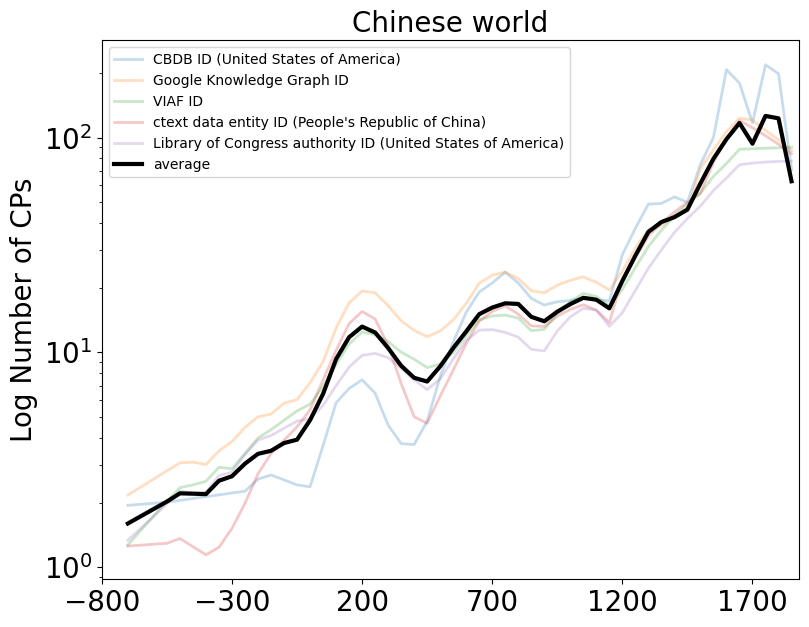

In [7]:
region_name = 'Chinese world'

df_fig_china = make_figure(df_fig_fifty,
            region_name=region_name,
            min_decade=-800,
            max_decade=1880,
            top_identifiers=5,
            one_id_country=False)

plt.show()


In [11]:
df_china = df_fig_fifty[df_fig_fifty['region_name']=='Chinese world']

# Calculate the mean score for each decade across all catalogs
mean_scores = df_fig_china.groupby('decade')['score'].mean().rename('mean_score')

# Merge the mean scores back to the original DataFrame
df = df_fig_china.merge(mean_scores, on='decade')
# Calculate the deviation of each score from the mean score of the same decade
df['deviation_from_mean'] = df['score'] - df['mean_score']

df

,identifier_name,country_name,region_name,decade,score,mean_score,deviation_from_mean
0,CBDB ID (United States of America),United States of America,Chinese world,-700,2,1.40,0.60
1,Google Knowledge Graph ID,,Chinese world,-700,2,1.40,0.60
2,Library of Congress authority ID (United State...,United States of America,Chinese world,-700,1,1.40,-0.40
3,VIAF ID,,Chinese world,-700,1,1.40,-0.40
4,ctext data entity ID (People's Republic of China),People's Republic of China,Chinese world,-700,1,1.40,-0.40
...,...,...,...,...,...,...,...
235,Google Knowledge Graph ID,,Chinese world,-300,4,3.25,0.75
236,Library of Congress authority ID (United State...,United States of America,Chinese world,-300,4,3.25,0.75
237,VIAF ID,,Chinese world,-300,4,3.25,0.75
238,ctext data entity ID (People's Republic of China),People's Republic of China,Chinese world,-300,1,3.25,-2.25


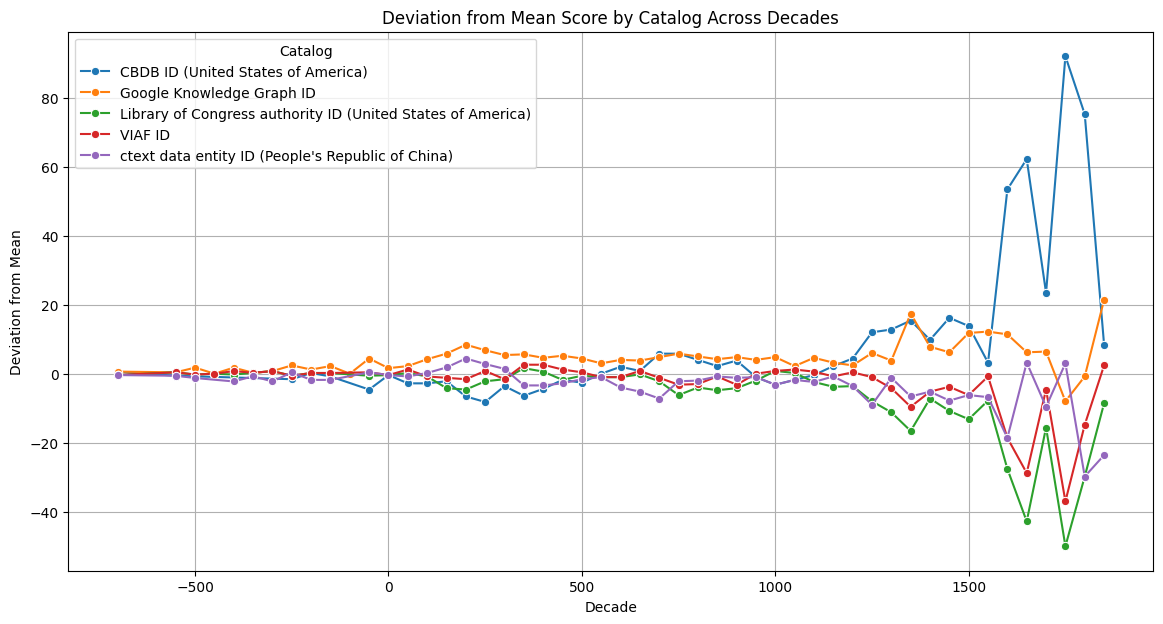

In [12]:
import seaborn as sns
# Plotting
plt.figure(figsize=(14, 7))
sns.lineplot(data=df, x='decade', y='deviation_from_mean', hue='identifier_name', marker='o', linestyle='-')
plt.title('Deviation from Mean Score by Catalog Across Decades')
plt.xlabel('Decade')
plt.ylabel('Deviation from Mean')
plt.grid(True)
plt.legend(title='Catalog')
plt.show()

In [10]:
df_corr = df_fig_china.pivot(index ='decade', columns = 'identifier_name', values = 'score')
df_corr = df_corr.fillna(0)
df_corr.corr().stack().mean()

0.9793338534931328